In [1]:
import numpy as np
from iTEBD_TEMPO import iTEBD_TEMPO
import matplotlib.pyplot as plt
import qutip as qt

# Bath and System Paramters

Here we choose for the bath correlation function a single exponential. This corresponds to the response of a single damped cavity mode.

In [2]:
G = 2
W = 1 + 1j * 1
BCF = lambda t: G * np.exp(-1j * t * W.imag - np.abs(t) * W.real)

For the system we choose a spin-$j$. The coupling operator is $S=J_z/\sqrt{2j}$. The initial state is a random coherent state. The system Hamiltonian is $H_S=J_x + 0.5 J_z$.

In [3]:
j = 1
S = qt.operators.jmat(j, 'z').full() / np.sqrt(2*j)
H_S = qt.operators.jmat(j, 'x').full() + .5 * qt.operators.jmat(j, 'z').full()
Rho_0 = qt.ket2dm(qt.spin_coherent(j, np.pi * np.random.rand(), 2 * np.pi * np.random.rand())).full()

These are the parameters for the time evolution. $\Delta$ is the time step used in the second order Trotter splitting between $H_S$ and the system bath interaction.

In [4]:
Delta = 0.1
T_max = 20
N = int(T_max / Delta)
T_eval = np.linspace(0, N * Delta, N + 1)

# Exact solution via Qutip 

For the special form of the bath correlation function we can get the exact dynamics from qutip by simulating the Markovian dynamics of the system and cavity mode.

In [5]:
NC = 20 # maximum excitation of the cavity mode
NS = int(2 * j + 1)
a = qt.destroy(NC)
S1 = qt.qeye(NS)
C1 = qt.qeye(NC)
Htot = qt.tensor(qt.Qobj(H_S), C1) + np.sqrt(G) * (qt.tensor(qt.Qobj(S), a.dag()) + qt.tensor(qt.Qobj(S).dag(), a)) + W.imag * qt.tensor(S1, a.dag() * a)
sol_qt = qt.mesolve(Htot, qt.tensor(qt.Qobj(Rho_0), qt.ket2dm(qt.basis(NC, 0))), T_eval, [np.sqrt(W.real * 2) * qt.tensor(S1, a)], [])

# iTEBD-TEMPO

The same calculation using iTEBD-TEMPO. Initially one has to pass the eigenvalues of $S$ (this operator must be diagonal), the time step $\Delta$, the bath correlation function, and the number of memory time steps $N_c$. $N_c$ should be large enough so that the bath correlation function has decayed to zero within the desired accuracy.

In [6]:
MyiTEBD_TEMPO = iTEBD_TEMPO(np.diagonal(S), Delta, BCF, 200)

This computes the influence functional using iTEBD.

In [7]:
MyiTEBD_TEMPO.compute_f(rank=100, rtol=1e-7)

building influence functional: 100%|████████████████████████████████████████████████| 200/200 [00:00<00:00, 902.73it/s]

rank  18


This function computes the time evolution for $N$ time steps for Hamiltonian $H_S$ and initial state $\rho_0$.

In [8]:
Rho_t = MyiTEBD_TEMPO.evolve(H_S, Rho_0, N)

time evolution running: 100%|██████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4187.44it/s]


We can also compute the steady state directly.

In [9]:
Rho_ss = MyiTEBD_TEMPO.steadystate(H_S)

We obtain the exact dynamics.

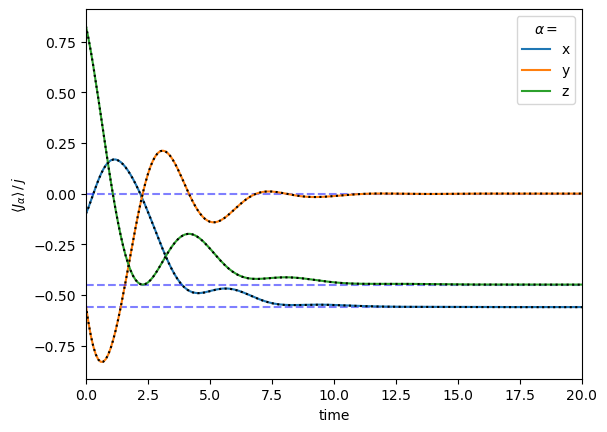

In [10]:
for al in ['x','y','z']:
    plt.plot(T_eval,0*T_eval+np.trace(Rho_ss @ qt.operators.jmat(j,al).full()).real / j, c='b',ls='--', alpha=.5)
    plt.plot(T_eval,np.einsum('ij,tji->t', qt.operators.jmat(j,al).full(), Rho_t).real/ j, label=al)
    plt.plot(T_eval,qt.expect(sol_qt.states, qt.tensor(qt.operators.jmat(j, al), C1)).real / j, c='k', ls='dotted')

plt.xlim(T_eval.min(), T_eval.max())
plt.xlabel('time')
plt.ylabel(r'$\langle J_\alpha \rangle\, /\, j$')
plt.legend(title=r'$\alpha=$')